# COGS 108 - EDA Checkpoint

# Names

- Jiayi Zhao
- Wenbo Hu
- Yunyi Huang
- Xiaotong Zeng

<a id='research_question'></a>
# Research Question

Is there a statistically significant relationship between the scale (burning area) of wildfire and climate variables in California that are associated with global warming such as relative humidity level, temperature, wind speed, and precipitation? Additionally, how can we utilize these climate variables to predict the wildfire event in California and the scale of wildfire?

# Setup

### Import Necessary Libraries

In [21]:
# Import pandas to read csv file and manage heterogenous data
import pandas as pd

# Import numpy to store numeric information and perform numerical analysis
import numpy as np

# Import seaborn and matplotlib to visualize data
import seaborn as sns
import matplotlib.pyplot as plt

# Import numpy to store numeric information and perform numerical analysis
import numpy as np

# Import seaborn and matplotlib to visualize data
import seaborn as sns
import matplotlib.pyplot as plt

#Import scipy to gather statistics
from scipy import stats

# Import patsy and statsmodels for regression analysis
import patsy
import statsmodels.api as sm

# Import math for using some math function
import math

import warnings

import shutil

import os

### Import the three data sets that we need

In [ ]:
# Load the California wildfire incidents data set in data frame
# We get this data set from Kaggle (https://www.kaggle.com/ananthu017/california-wildfire-incidents-20132020)
wildfire = pd.read_csv("California_Fire_Incidents.csv")


# Load the US weather station ID data set in data frame
# We get the Integrated Surface Data (ISD) station list from ncdc.noaa.gov
station = pd.read_csv("https://www1.ncdc.noaa.gov/pub/data/noaa/isd-history.csv")


# Load the US weather daily data set from 2013 to 2019 in data frame
# We get this data from ncei.noaa.gov and download to the local.
# (https://www.ncei.noaa.gov/data/global-summary-of-the-day/archive/)
for dirname, _, filenames in os.walk('/Users/wenbohu/Desktop/Weather'):
    for filename in filenames:
        print((os.path.join(dirname, filename)))
        
# get all subdiretory of all tables
file_dict ={}
for path, dirs, files in os.walk('/Users/wenbohu/Desktop/Weather', topdown=False):
    file_dict[path]=files
    
paths = list(file_dict.keys())

events = []
for path in paths:
    events += [os.path.join(path,file) for file in file_dict[path]]
    

# Data Cleaning

Since we have three data set, we choose to clean them seperatly and then merge these dataset by locations.

### First, we clean the California wildfire incidents data set


Since we only need the dates, acres burned (scale), and county name for the following analysis, we update these information back to *'wildfire'*.

In [ ]:
# delete the irrelevant columns
wildfire = wildfire[['AcresBurned','Started','Counties', 'Latitude', 'Longitude']]

# change the started time into date
wildfire['Started'] = [x[0:10] for x in wildfire['Started']]

# change the 'Started' column name into 'Date'
wildfire = wildfire.rename({'Started':'Date'}, axis='columns')

#drop the null values 
wildfire['Latitude'] = wildfire['Latitude'].apply(lambda x: np.nan if x == 0 else x)
wildfire = wildfire.dropna().reset_index(drop=True) 


Now take a look on the *wildfire* dataframe

In [ ]:
wildfire.head()

### Second, clean the Integrated Surface Data (ISD) station list

In [ ]:
# Since the weather station ID is a combination of column 'USAF' and 'WBAN',
# we combine these two columns into a new column called 'ID'
station['ID']= station['USAF'].astype(str) + station['WBAN'].astype(str)

# we only analyze California weather
station = station[(station['STATE']=='CA') & (station['CTRY']=='US')].reset_index(drop=True)

# station only need to include the ID and the nameof the station
pd.set_option("max_rows", None)

Now take a look on the *station* dataframe

In [ ]:
station.head()

### Thrid, we merge the wildfire and station ID dataframes by matching the LATITUDE and LONGTITUDE of the wildfire incident locations and weather stations. 
We compare each error index (0.1, 0.2, 0.3, 0.5) in order to find which diameter we should choose for more unique stations is determined.

In [ ]:
IDlist = []
for i,j in wildfire.iterrows():
    before = len(IDlist)
    for a,b in station.iterrows():
        #about 50km * 40km (just for first time test then tried 0.3, 0.1, and 0.2)
        if (((b['LAT'] <= j['Latitude'] + 0.2) and (b['LAT'] >= j['Latitude'] - 0.2)) 
        and (( b['LON'] <= j['Longitude'] + 0.2) and ( b['LON'] >= j['Longitude'] - 0.2))):
            IDlist.append(b['ID'])
            break
    after = len(IDlist)
    if (before == after):
        IDlist.append("Not_Found")

In [ ]:
# 0.5-95 0.3-119 0.1-119 0.2-127(THIS IS THE BEST!!!!)
# when 0.1 it's also 119 but lots of not found values
unique = []
for x in IDlist:
    if x not in unique:
        unique.append(x)
print(len(unique))

Then, we create a dataframe called *matched_wildfire* that consists the scale, date, county name, latitude, and longitude of the wildfire incidents and the weather station ID in that incident area.

In [ ]:
IDlist = []
row_fire = []
row_ID =[]

# create a new dataframe to store these matched data
matched_wildfire = pd.DataFrame(columns=wildfire.columns)

# iterate the rows in wildfire and station to find the matched data
for i,j in wildfire.iterrows():
    for a,b in station.iterrows():
        if (((b['LAT'] <= j['Latitude'] + 0.2) and (b['LAT'] >= j['Latitude'] - 0.2)) 
        and (( b['LON'] <= j['Longitude'] + 0.2) and ( b['LON'] >= j['Longitude'] - 0.2))):
            IDlist.append(b['ID'])
            row_ID.append(b['ID'])
            row_fire.append(list(j))
            break
            
matched_wildfire = matched_wildfire.append(pd.DataFrame(row_fire,columns=wildfire.columns))
matched_wildfire = matched_wildfire.assign(ID=row_ID)

Now, take a look on the *matched_wildfire*

In [ ]:
matched_wildfire.head()

### Fourth, using the *matched_wildfire* data frame merge with the weather dataset from 2013 to 2019 so that every wildfire incident has the weather data of that day. 

Take a brief look on how the dataset of one station in the weather dataset in 2013 looks like

In [ ]:
example = pd.read_csv("/Users/wenbohu/Desktop/Weather/2013/40854099999.csv")
example.head()

Loop the *matched_wildfire* and find the weather data with the matched date and station ID

In [ ]:
# Get the weather information of wildfire start date 
row_weather = []
join_id = []
num = 1

# create a data frame to store the weather data
weather = pd.DataFrame(columns = example.columns)

for i, j in matched_wildfire.iterrows():
    for file in events:
        if num in join_id:
            break
        if (file[-15:-4] == j['Station_ID']):
            temp = pd.read_csv(file)
            for a, b in temp.iterrows():
                if (b["DATE"] == j['Date']):
                    row_weather.append(list(b))
                    join_id.append(num)
                    break 
    num += 1

Append these matched weather data to *weather*

In [ ]:
weather = pd.DataFrame(columns = example.columns)
weather = weather.append(pd.DataFrame(row_weather, columns = example.columns))
weather = weather.assign(Join_ID = join_id)

Now, take a look on the *weather*

In [ ]:
weather.head()

Merge *matched_wildfire* and *weather*, and store this merge dataset in local as a csv file

In [ ]:
dataframe = matched_wildfire.merge(weather, on = 'Join_ID')
dataframe.to_csv('/Users/wenbohu/Desktop/df.csv')

### Lastly, import and clean this final data frame

The weather variable columns decription:
 - TMP: Mean temperature for the day in degrees Fahrenheit to tenths. Missing = 9999.9
 - DEWP: Mean dew point for the day in degrees Fahrenheit to tenths. Missing = 9999.9
 - WDSD: Mean wind speed for the day in knots to tenths. Missing = 999.9
 - PRCP: Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with

In [191]:
df = pd.read_csv('df.csv')

df = df[['AcresBurned', 'Date', 'Counties','TEMP','DEWP','WDSP','PRCP']] 

# By the column description, we replace the missing value (9999.9 or 999.9) with np.nan
df['TEMP'] = df['TEMP'].replace(9999.9, np.nan, regex=True) 
df['DEWP'] = df['DEWP'].replace(9999.9, np.nan, regex=True) 
df['WDSP'] = df['WDSP'].replace(999.9, np.nan, regex=True) 
# Drop the NAN value
df = df.dropna(subset=['TEMP','DEWP','WDSP'])

# convert the temperature and the dewpoint from Fahrenheit to Celsius
df['TEMP'] = 5.0 / 9.0 * (df['TEMP'] - 32.0)
df['DEWP'] = 5.0 / 9.0 * (df['DEWP'] - 32.0)

# calculate saturation vapor pressure(Es) and actual vapor pressure(E) in millibars.
df['Es'] = 6.11*10.0**(7.5*df['TEMP']/(237.7+df['TEMP']))
df['E'] = 6.11*10.0**(7.5*df['DEWP']/(237.7+df['DEWP']))

# Once you have the saturation vapor pressure and the actual vapor pressure, 
# relative humidity(RH) can be computed by dividing the actual vapor pressure by the saturation vapor pressure 
# and then multiplying by 100 to convert the quantity to a percent.
df ['RelaHumPct'] = (df['E']/df['Es'])*100

# Rename the columns
df = df.rename(columns={'Counties':'County','TEMP':'Temp','DEWP':'DewPt','WDSP': 'WindSpd','PRCP':'Precipitation'}) 

#### The Final Dataframe

Description on the columns of the final dataframe:
 - AcresBurned: The area of the wildfire incident burns in degree acre
 - Date: The date of the wildfire incident
 - County: The county where the wildfire incident belongs
 - Temp: Mean temperature for the day in degrees Celsius
 - DewPt: Mean dew point for the day in degrees Celsius
 - WindSpd: Mean wind speed for the day in knots to tenths.
 - Precipitation: Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with
 - Es: Saturation vapor pressure in millibars.
 - E: Actual vapor pressure in millibars.
 - RelaHumPct: Relative humidity for the day in perpercentage

In [192]:
df.head()

,AcresBurned,Date,County,Temp,DewPt,WindSpd,Precipitation,Es,E,RelaHumPct
1,712.0,2013-07-19,Kern,26.944444,1.000000,13.2,0.0,35.452296,6.568427,18.527509
3,305.0,2013-10-04,Butte,19.000000,-2.555556,10.1,0.0,21.936328,5.064435,23.086979
4,298.0,2013-06-03,Butte,27.111111,10.611111,3.5,0.0,35.800090,12.780260,35.698961
5,240.0,2013-06-08,Alameda,28.666667,11.777778,4.0,0.0,39.192166,13.807472,35.230183
6,200.0,2013-07-04,Tehama,36.500000,9.222222,10.0,0.0,60.869547,11.645454,19.131822


# Data Analysis & Results (EDA)

In [193]:
# Select Relevant Columns
df = df[['AcresBurned', 'Temp', 'DewPt', 'WindSpd', 'Precipitation', 'RelaHumPct']].reset_index(drop=True)

# Checking the data type
print(df.dtypes)

# Assign the column variables
acres_burned = df['AcresBurned']
temp = df['Temp']
dew_pt = df['DewPt']
wind_spd = df['WindSpd']
precip = df['Precipitation']
humid = df['RelaHumPct']

#Get a preview of the dataset
df.head()

AcresBurned      float64
Temp             float64
DewPt            float64
WindSpd          float64
Precipitation    float64
RelaHumPct       float64
dtype: object


,AcresBurned,Temp,DewPt,WindSpd,Precipitation,RelaHumPct
0,712.0,26.944444,1.000000,13.2,0.0,18.527509
1,305.0,19.000000,-2.555556,10.1,0.0,23.086979
2,298.0,27.111111,10.611111,3.5,0.0,35.698961
3,240.0,28.666667,11.777778,4.0,0.0,35.230183
4,200.0,36.500000,9.222222,10.0,0.0,19.131822


## Check for outliers

count       372.000000
mean       6147.862903
std       42796.625726
min           0.000000
25%          33.000000
50%          78.000000
75%         241.750000
max      410203.000000
Name: AcresBurned, dtype: float64

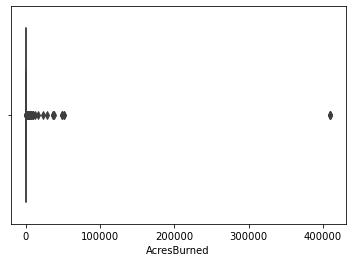

In [194]:
#Acres_burned
sns.boxplot(x=acres_burned)
acres_burned.describe()

#### For Acres Burned, there is an obvious outlier around 400000 which pulls the mean toward the larger end. Thus, we are going to exclude the cluster around 400000 in our analysis.

count    372.000000
mean      22.626045
std        5.260780
min        2.611111
25%       19.041667
50%       22.972222
75%       26.236111
max       41.222222
Name: Temp, dtype: float64

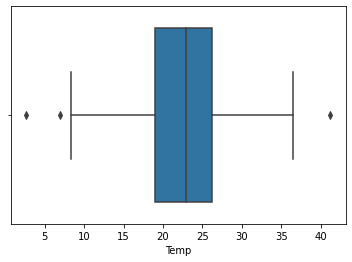

In [195]:
sns.boxplot(x=temp)
temp.describe()

#### For temperature, the median clusters around 23 degree celcius and the data seems to follow a nice normal distribution with a few outliers that are below 10 degrees and above 35 degrees.

count    372.000000
mean       7.783602
std        6.419261
min      -18.333333
25%        4.722222
50%        9.111111
75%       12.138889
max       23.666667
Name: DewPt, dtype: float64

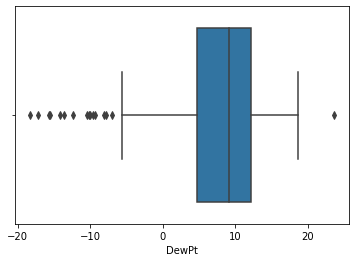

In [196]:
sns.boxplot(x=dew_pt)
dew_pt.describe()

#### For Dew Point, the median clusters around 9 and the data seems to be skewed to the left with a few outliers that are below -5 and above 20.

count    372.000000
mean       6.004301
std        2.880510
min        0.300000
25%        4.300000
50%        5.400000
75%        6.900000
max       22.000000
Name: WindSpd, dtype: float64

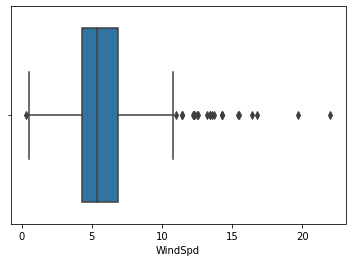

In [197]:
sns.boxplot(x=wind_spd)
wind_spd.describe()

#### For Wind Speed, the median clusters around 5.4 and the data seems to be skewed to the right with a few outliers that above 10.

count    372.000000
mean      41.945580
std       17.166863
min        6.578408
25%       29.354164
50%       38.853739
75%       53.300922
max       91.355476
Name: RelaHumPct, dtype: float64

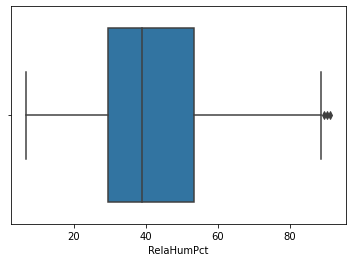

In [198]:
sns.boxplot(x=humid)
humid.describe()

#### For Relative Humidity Percent, the median clusters around 39 and the data seems to follow a weak normal distribution with a light skew to the right having a few outliers that above 85.

count    372.000000
mean       0.005376
std        0.074306
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.360000
Name: Precipitation, dtype: float64

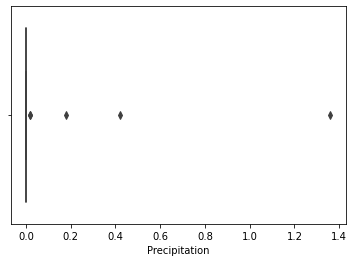

In [199]:
sns.boxplot(x=precip)
precip.describe()

#### For Precipitatin, the median is 0 and the data is skewed to the right due to a few days of rain. 

### Outlier Summary

- #### For Acres Burned, there is an obvious outlier around 400000 which pulls the mean toward the larger end. Thus, we are going to exclude the cluster around 400000 in our analysis.
- #### For temperature, the median clusters around 23 degree celcius and the data seems to follow a nice normal distribution with a few outliers that are below 10 degrees and above 35 degrees.
- #### For Dew Point, the median clusters around 9 and the data seems to be skewed to the left with a few outliers that are below -5 and above 20.
- #### For Wind Speed, the median clusters around 5.4 and the data seems to be skewed to the right with a few outliers that above 10.
- #### For Relative Humidity Percent, the median clusters around 39 and the data seems to follow a weak normal distribution with a light skew to the right having a few outliers that above 85.
- #### For Precipitation, the median is 0 and the data is skewed to the right due to a few days of heavy rain. 

## Remove Outliers
After skimming through the dataset, we decide to drop the precipitation because the mean, the median, and the 75% quantile of the variable are all around 0.00 which indicates that there are only a few days of rain in our dataset. Thus, precipitation most likely will not affect have a strong influence on the acres burned. 

In [200]:
df = df.drop(['Precipitation'], axis=1)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

AcresBurned    208.750000
Temp             7.194444
DewPt            7.416667
WindSpd          2.600000
RelaHumPct      23.946758
dtype: float64


In [201]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

(283, 5)

## Distribution After Removing the outliers

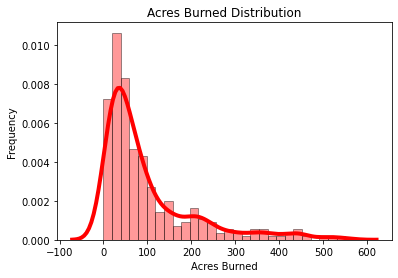

In [202]:
# AcresBurned
acres_burned = df['AcresBurned']
ax = sns.distplot(acres_burned, hist=True, kde=True, 
                  bins=int(len(acres_burned)/10),
                  color='red',hist_kws={'edgecolor':'black'}, 
                  kde_kws={'linewidth':4})

ax.set(xlabel='Acres Burned', ylabel='Frequency', title='Acres Burned Distribution')
plt.show()

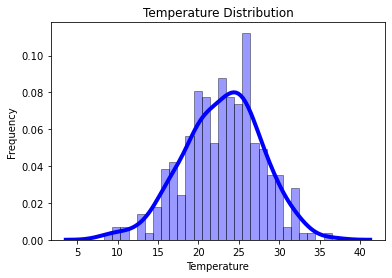

In [203]:
#Temperature
temp = df['Temp']
ax = sns.distplot(temp, hist=True, kde=True, 
                  bins=int(len(temp)/10),
                  color='blue',hist_kws={'edgecolor':'black'}, 
                  kde_kws={'linewidth':4})

ax.set(xlabel='Temperature', ylabel='Frequency', title='Temperature Distribution')
plt.show()

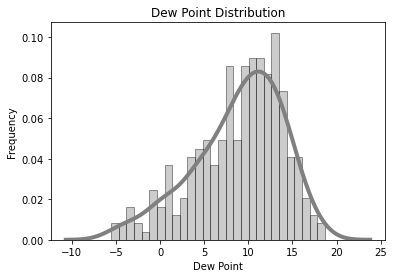

In [204]:
#DewPt
dew_pt = df['DewPt']
ax = sns.distplot(dew_pt, hist=True, kde=True, 
                  bins=int(len(dew_pt)/10),
                  color='grey',hist_kws={'edgecolor':'black'}, 
                  kde_kws={'linewidth':4})

ax.set(xlabel='Dew Point', ylabel='Frequency', title='Dew Point Distribution')
plt.show()

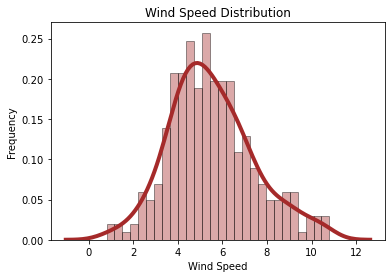

In [205]:
#Wind Speed
wind_spd = df['WindSpd']
ax = sns.distplot(wind_spd, hist=True, kde=True, 
                  bins=int(len(wind_spd)/10),
                  color='brown',hist_kws={'edgecolor':'black'}, 
                  kde_kws={'linewidth':4})

ax.set(xlabel='Wind Speed', ylabel='Frequency', title='Wind Speed Distribution')
plt.show()

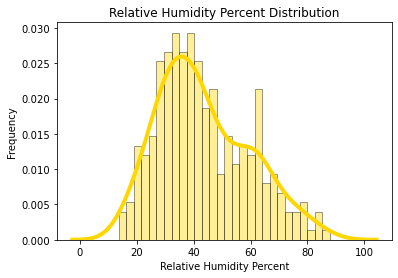

In [206]:
#Relative Humidity Percent
humid = df['RelaHumPct']
ax = sns.distplot(humid, hist=True, kde=True, 
                  bins=int(len(humid)/10),
                  color='gold',hist_kws={'edgecolor':'black'}, 
                  kde_kws={'linewidth':4})

ax.set(xlabel='Relative Humidity Percent', ylabel='Frequency', title='Relative Humidity Percent Distribution')
plt.show()

### After removing the outliers, 
- #### AcresBurned is still skewed to the right with a median around 45; 
- #### Temperature follows a normal distribution with center around 24;  
- #### Dew Point has a slight skew to the left with a median around 12; 
- #### Wind Speed follows a normal distribution with center around 5; 
- #### Relative Humidity Percent has a slight skew to the right with a median around  is still skewed to the right with a median around 40.